In [3]:
import shutil
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
from tensorflow.keras.models import load_model, Model
from tasks.utils.tf_data_utils import build_data_pipeline

In [7]:
def load_saved_model(model_path: str):
    model = load_model(model_path)
    return model

In [8]:
model = load_saved_model('/home/ariya/workspace/models/animals10_classifier_second')

In [105]:
annotation_df = pd.read_csv('/home/ariya/workspace/datasets/animals10-dvc/annotation_df.csv')
classes = ["butterfly", "cat", "chicken", "cow", "dog", 
        "elephant", "horse", "sheep", "spider", "squirrel"]
img_size = [50,50]
batch_size = 1

test_ds = build_data_pipeline(annotation_df, classes, 'test', img_size, batch_size, 
                                do_augment=False, augmenter=None)
y_true_bin = np.concatenate([y for _, y in test_ds], axis=0)
y_true = np.argmax(y_true_bin, axis=1)

In [106]:
y_pred_prob = model.predict(test_ds)

2618/2618 [==============================] - 10s 4ms/step


In [107]:
y_pred = tf.argmax(y_pred_prob, axis=1)

In [108]:
y_true.shape, y_pred.shape

((2618,), TensorShape([2618]))

In [102]:
# mock up multi-label pred
y_pred_prob = np.random.rand(10,10)
y_pred = (y_pred_prob > 0.7).astype(np.int8)
y_true = (y_pred_prob > 0.5).astype(np.int8)

In [103]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score

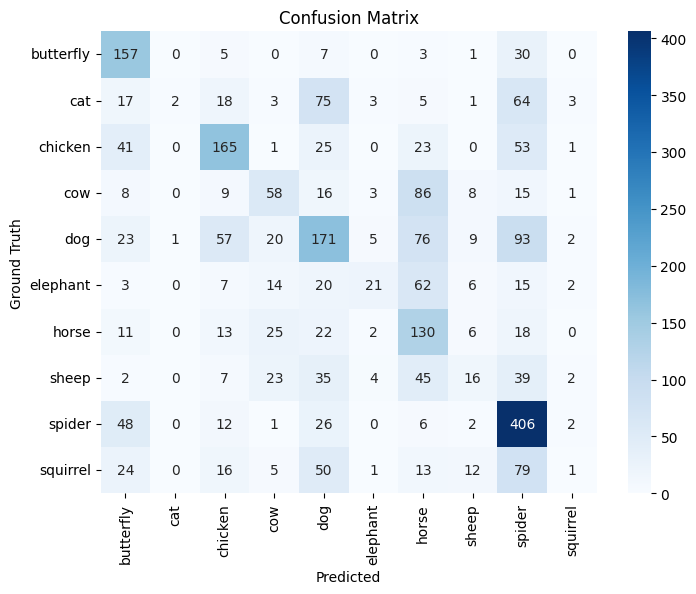

AUC: 0.838165796139595


,precision,recall,f1-score,support
butterfly,0.470060,0.773399,0.584730,203.000000
cat,0.666667,0.010471,0.020619,191.000000
chicken,0.533981,0.533981,0.533981,309.000000
cow,0.386667,0.284314,0.327684,204.000000
dog,0.382550,0.374179,0.378319,457.000000
elephant,0.538462,0.140000,0.222222,150.000000
horse,0.289532,0.572687,0.384615,227.000000
sheep,0.262295,0.092486,0.136752,173.000000
spider,0.500000,0.807157,0.617490,503.000000
squirrel,0.071429,0.004975,0.009302,201.000000


In [111]:
# Calculate precision, recall, f1-score
type = 'multi-class'
if type == 'multi-class':
    
    # Create a confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Plot the confusion matrix
    fig = plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=True,
               xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Ground Truth')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Calculate AUC
    roc_auc = roc_auc_score(y_true, y_pred_prob, average='macro', multi_class='ovr')
    
    # Print classification report
    report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
    final_report = pd.DataFrame(report).T
    print('AUC:', roc_auc)
    
elif type == 'multi-label':
    
    roc_auc = roc_auc_score(y_true, y_pred_prob, average=None, multi_class='ovr')
    
    # Print classification report
    report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
    final_report = pd.DataFrame(report).T
    final_report['AUC'] = list(roc_auc) + (4*[None])

final_report    

In [114]:
isinstance(roc_auc, float)

True

In [1]:
from importlib import import_module

In [2]:
mod = import_module('flows.full_flow', package='flows')

In [3]:
mod.start({'add_text': 'eiei'})

Hi Mom!
added eiei


---

In [71]:
import os
import cv2
import base64
import numpy as np
import requests
import random
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image

In [72]:
img_root = '/home/ariya/workspace/datasets/animals10-dvc/images'
img_class = 'butterfly'
img_dir = os.path.join(img_root, img_class)
img_file = random.choice(os.listdir(img_dir))
print(img_file)
img_path = os.path.join(img_dir, img_file)

ea35b80a2ef1043ed1584d05fb1d4e9fe777ead218ac104497f5c97faeebb5bb_640.jpg


In [83]:
ori_image = cv2.imread(img_path)

In [73]:
res = requests.post('http://127.0.0.1:4242/predict/',
                    files={'item':open(img_path, 'rb')}
                    )
print(res.json())

{'message': 'No model. You have to setup model with the /update_model endpoint first.'}


In [74]:
res = requests.put('http://127.0.0.1:4242/update_model/animals10_classifierXD.yaml')
print(res.json())

{'message': 'Updating model failed due to failure in model loading method'}


In [75]:
res = requests.put('http://127.0.0.1:4242/update_model/animals10_classifier.yaml')
print(res.json())

{'message': 'Update the model successfully'}


In [78]:
res = requests.post('http://127.0.0.1:4242/predict/',
                    files={'item':open(img_path, 'rb')}
                    )
res = res.json()
res.keys()

dict_keys(['prediction', 'overlaid_img', 'raw_hm_img', 'message'])

In [79]:
raw_hm_bytes = res.pop('raw_hm_img')
overlaid_hm_bytes = res.pop('overlaid_img')
res

{'prediction': {'butterfly': 0.969391942024231,
  'cat': 0.00346136512234807,
  'chicken': 5.091017374070361e-05,
  'cow': 3.8311532080115285e-06,
  'dog': 0.0029960433021187782,
  'elephant': 9.680839951897724e-08,
  'horse': 6.2787119532004e-05,
  'sheep': 3.5267048588139005e-06,
  'spider': 0.023964786902070045,
  'squirrel': 6.465009937528521e-05},
 'message': 'Success'}

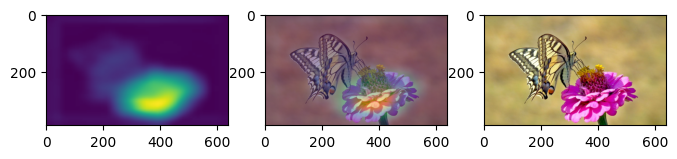

In [85]:
plt.figure(figsize=(8,8))


for idx, img_str in enumerate([raw_hm_bytes, overlaid_hm_bytes]):
    bytes_str = img_str.encode('utf-8')
    prediction_image_byte = base64.b64decode(bytes_str)
    prediction_image_arr = np.frombuffer(prediction_image_byte, dtype=np.uint8)
    prediction_image_arr = cv2.imdecode(prediction_image_arr,flags=cv2.IMREAD_COLOR)
    plt.subplot(1, 3, idx+1)
    plt.imshow(cv2.cvtColor(prediction_image_arr, cv2.COLOR_BGR2RGB))

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(ori_image, cv2.COLOR_BGR2RGB))

plt.show()